In [1]:
import os
import pandas as pd
import numpy as np
import logging
from tqdm import tqdm

In [2]:
data_path = "/project/datacamp/team11/data/preprocessed"
sample_annotation_file = os.path.join(data_path, "..", "igsr-1000 genomes 30x on grch38.tsv")
chr_list = [str(x) for x in range(1,23)]
gt_dict = {"0|0" :0, "0|1" : 1, "1|0" : 2, "1|1" : 3 } # genotype dict for converting string-> inteter 

sample_annotation = pd.read_csv(sample_annotation_file, sep="\t")

### combine the matrix

In [3]:
def read_data(path, target_name):
    mat_file_name = os.path.join(path, f"{target_name}_matrix.npy")
    variant_info_file_name = os.path.join(path, f"{target_name}_variant.csv")
    if (not os.path.isfile(mat_file_name)) or (not os.path.isfile(variant_info_file_name)):
        logging.warning(f"can not find preprocessed file for chromosome {chr}")
        return;

    gt_mat = np.load(mat_file_name)
    variant_info_df = pd.read_csv(variant_info_file_name, dtype = str)
    assert gt_mat.shape[1] == variant_info_df.shape[0]
    assert gt_mat.shape[0] == sample_annotation.shape[0]

    return gt_mat, variant_info_df


#for chr in chr_list:
#    read_data(output_path, f"chr{chr}")


### data analysis and visualization

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
gt_mat, variant_info_df = read_data(data_path, f"chr22")

print(f"genotype matrix shape (#samples, #features) : {gt_mat.shape}")
print(f"sample annotations (#samples, ) : {sample_annotation.shape}")
print(f"variant info dataframe (#features, ): {variant_info_df.shape}")

genotype matrix shape (#samples, #features) : (3202, 925730)
sample annotations (#samples, ) : (3202, 9)
variant info dataframe (#features, ): (925730, 4)


In [17]:
supporting_sample_count = (gt_mat != 0).sum(axis = 0)
supporting_count_filter = supporting_sample_count > 5

In [18]:
supporting_count_filter.sum(), supporting_count_filter.shape

(465580, (925730,))

In [20]:
sample_annotation["Superpopulation code"].value_counts()
# sample_annotation["Population name"].value_counts()

Superpopulation code
AFR        893
EUR        632
SAS        601
EAS        585
AMR        490
EUR,AFR      1
Name: count, dtype: int64

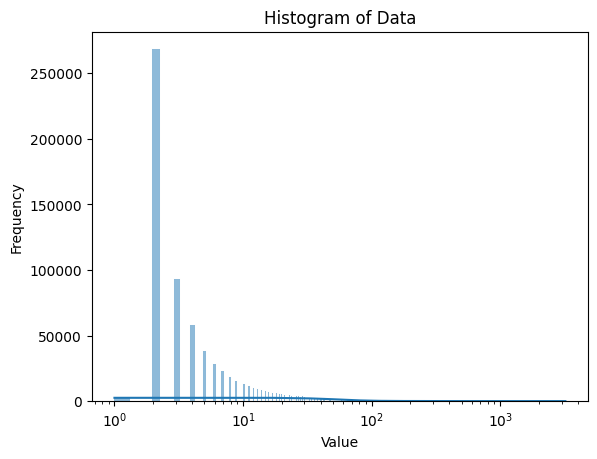

In [24]:
sns.histplot(supporting_sample_count, bins=10000, kde=True)  # 'bins' controls the number of bins, 'kde' adds a Kernel Density Estimate plot

plt.xscale('log')

plt.title('Histogram of Data')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.show()